# Get started with the Sampler primitive

In this tutorial we will show you how to set up the Qiskit Runtime `Sampler` primitive, explore the different options you can use to configure it, and invoke the primitive efficiently inside a session.

## Primitives

Primitives are core functions that make it easier to build modular algorithms and applications. 

Rather than simply returning counts, they return more immediately meaningful information. 

Additionally, they provide a seamless way to access the latest advancements in IBM Quantum hardware and software.

The initial release of Qiskit Runtime includes two primitives:

**Sampler:** Generates quasi-probabilities from input circuits.

**Estimator:** Calculates expectation values from input circuits and observables.

In this tutorial we will focus on the `Sampler` primitive. There is a separate tutorial on [Getting started with the Estimator primitive](how-to-getting-started-with-estimator.ipynb).

## Using the Sampler primitive

Similar to the `Backend` base class, there is an `Sampler` base class defined in Qiskit Terra that standardizes the way users interact with all `Sampler` implementations.
This allows users to easily change their choice of simulator or device for performing expectation value calculations, even if the underlying implementation is different. 

In this section we will be using the default implementation in Qiskit Terra, which uses a local state vector simulator.

### 1. Create a circuit

You will need at least one quantum circuit to prepare our system in a precise quantum state for study. Our examples all have circuits in them, but you can use Qiskit to create your own. To learn how to create circuits by using Qiskit, see the [Circuit basics tutorial](https://qiskit.org/documentation/tutorials/circuits/01_circuit_basics.html).

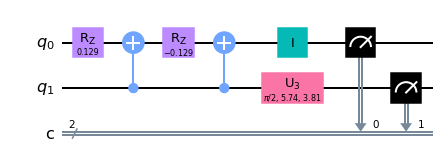

In [1]:
from qiskit.circuit.random import random_circuit

circuit = random_circuit(2, 2, seed=0, measure=True).decompose(reps=1)
display(circuit.draw("mpl"))

### 2. Initialize a Sampler class

The next step is to create an instance of an `Sampler` class. This can be any `Sampler` class that complies with the `Sampler` primitive specification. For simplicity, we will use Qiskit Terra's `qiskit.primitives.Sampler` class, based on the [`Statevector` construct](https://qiskit.org/documentation/stubs/qiskit.quantum_info.Statevector.html?highlight=statevector#qiskit.quantum_info.Statevector) (that is, algebraic simulation).

In [2]:
from qiskit.primitives import Sampler

sampler = Sampler()

### 3. Invoke the Sampler and get results

To estimate the quasi-probability distribution of the circuit output, invoke the `run()` method of the `Sampler` instance you just created and pass in the circuit as an input parameter. This method call is asynchronous, and you will get a `Job` object back. You can use this object to query for information like `job_id()` and `status()`.

In [3]:
job = sampler.run(circuit)
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: 979495e7-7f0d-4b92-acbc-19da7dad864d
>>> Job Status: JobStatus.DONE


The `result()` method of the job will return the `SamplerResult`, which includes both the quasi-distribution and job metadata. 

In [4]:
result = job.result()
print(f">>> {result}")
print(f"  > Quasi-distribution: {result.quasi_dists[0]}")

>>> SamplerResult(quasi_dists=[{0: 0.4999999999999999, 1: 0.0, 2: 0.4999999999999998, 3: 0.0}], metadata=[{}])
  > Quasi-distribution: {0: 0.4999999999999999, 1: 0.0, 2: 0.4999999999999998, 3: 0.0}


You can keep invoking the `run()` method again with the different inputs:

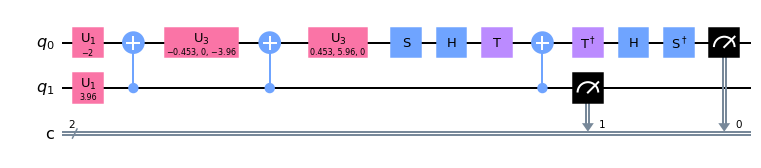

>>> Quasi-distribution: {0: 0.9999999999999991, 1: 6.580329297619248e-33, 2: 0.0, 3: 0.0}


In [5]:
circuit = random_circuit(2, 2, seed=1, measure=True).decompose(reps=1)

job = sampler.run(circuit)
result = job.result()

display(circuit.draw("mpl"))
print(f">>> Quasi-distribution: {result.quasi_dists[0]}")

You can also provide compound inputs to the `run()` method:

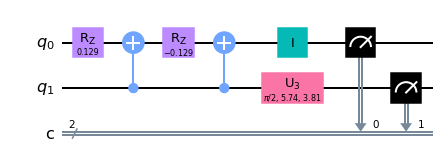

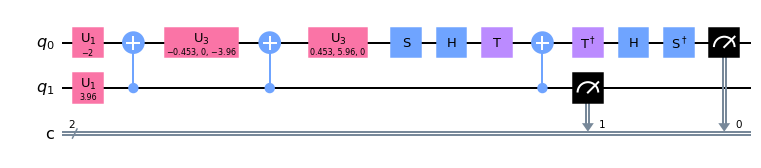

>>> Quasi-distribution: [{0: 0.4999999999999999, 1: 0.0, 2: 0.4999999999999998, 3: 0.0}, {0: 0.9999999999999991, 1: 6.580329297619248e-33, 2: 0.0, 3: 0.0}]


In [6]:
circuits = (
    random_circuit(2, 2, seed=0, measure=True).decompose(reps=1),
    random_circuit(2, 2, seed=1, measure=True).decompose(reps=1),
)

job = sampler.run(circuits)
result = job.result()

[display(cir.draw("mpl")) for cir in circuits]
print(f">>> Quasi-distribution: {result.quasi_dists}")

Or use parameterized circuits:

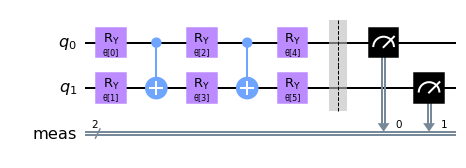

>>> Parameter values: [0, 1, 2, 3, 4, 5]
>>> Quasi-distribution: {0: 0.17158451004815306, 1: 0.0041370682135240654, 2: 0.20402129418492707, 3: 0.6202571275533961}


In [7]:
from qiskit.circuit.library import RealAmplitudes

circuit = RealAmplitudes(num_qubits=2, reps=2).decompose(reps=1)
circuit.measure_all()
parameter_values = [0, 1, 2, 3, 4, 5]

job = sampler.run(circuit, parameter_values)
result = job.result()

display(circuit.draw("mpl"))
print(f">>> Parameter values: {parameter_values}")
print(f">>> Quasi-distribution: {result.quasi_dists[0]}")

## Using Qiskit Runtime Sampler

In this section we will go over how to use Qiskit Runtime's implementation of the `Sampler` primitive.

### 1. Initialize the account

Since Qiskit Runtime `Sampler` is a managed service, you will first need to initialize your account. You can then select the simulator or real backend you want to use to calculate the expectation value.

Follow the steps in the [getting started guide](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/getting_started.html) if you don't already have an account set up.

In [8]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibmq_qasm_simulator")

### 2. Create a circuit

Just like the section before, you will need at least one circuit as the input to the `Sampler` primitive.

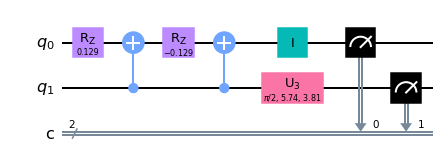

In [9]:
from qiskit.circuit.random import random_circuit

circuit = random_circuit(2, 2, seed=0, measure=True).decompose(reps=1)
display(circuit.draw("mpl"))

### 3. Initialize the Qiskit Runtime Sampler

Here we are initializing an instance of `qiskit_ibm_runtime.Sampler` rather than `qiskit.primitives.Sampler` to use Qiskit Runtime's implementation of the `Sampler`. 

When you initialize the `Sampler`, you'll need to pass in the backend you previously selected as the target device (or simulator), using the `session` parameter. This automatically opens a session for that backend. We will talk more about session in a later section.

In [10]:
from qiskit_ibm_runtime import Sampler

sampler = Sampler(session=backend)

### 4. Invoke the Sampler and get results

You can then invoke the `run()` method to calculate expectation values for the input circuit(s) and observable(s).

In [11]:
job = sampler.run(circuit)
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: cdkrk4qan60ka16e6v0g
>>> Job Status: JobStatus.RUNNING


In [12]:
result = job.result()
print(f">>> {result}")
print(f"  > Quasi-distribution: {result.quasi_dists[0]}")
print(f"  > Metadata: {result.metadata[0]}")

>>> SamplerResult(quasi_dists=[{2: 0.49275, 0: 0.50725}], metadata=[{'header_metadata': {}, 'shots': 4000}])
  > Quasi-distribution: {2: 0.49275, 0: 0.50725}
  > Metadata: {'header_metadata': {}, 'shots': 4000}


## Options

Primitives come with several options that are grouped into different categories. Commonly used options, such as `resilience_level`, are at the first level.

![options](images/options.png)

You can use the [Options](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/stubs/qiskit_ibm_runtime.options.Options.html#qiskit_ibm_runtime.options.Options) class to specify different options.

In the following example, we create an instance of the `Options` class. `optimization_level` is a first level option and can be passed as an input parameter. Options related to the execution environment are passed using the `environment` parameter.

In [13]:
from qiskit_ibm_runtime import Options

options = Options(optimization_level=3, environment={"log_level": "INFO"})

`Options` supports auto-complete. Once you create an instance of the `Options` class, you can use auto-complete to see what options are available. If you choose one of the categories, you can use auto-complete again to see what options are available under that category. 

In [14]:
from qiskit_ibm_runtime import Options

options = Options()
options.resilience_level = 1
options.execution.shots = 2048

When creating an instance of the `Sampler` class, you can pass in the `options` you just created. Those options will then be applied when you use `run()` to perform the calculation. 

In [15]:
sampler = Sampler(session=backend, options=options)
result = sampler.run(circuit).result()
print(f">>> Metadata: {result.metadata[0]}")

>>> Metadata: {'header_metadata': {}, 'shots': 2048, 'readout_mitigation_overhead': 1.0, 'readout_mitigation_time': 0.028210751246660948}


You can also pass in options through the `run()` method. This will overwrite the options you specified when creating the `Sampler` instance for that particular execution. 

Since most users will only overwrite a handful of options at the job level, it is not necessary to specify the category the options are in. The following code, for example, specifies `shots=1024` rather than `execution={"shots": 1024}` (which is also valid). 

In [16]:
sampler = Sampler(session=backend, options=options)
result = sampler.run(circuit, shots=1024).result()
print(f">>> Metadata: {result.metadata[0]}")

>>> Metadata: {'header_metadata': {}, 'shots': 1024, 'readout_mitigation_overhead': 1.0, 'readout_mitigation_time': 0.002864845097064972}


### Error suppression and mitigation

`optimization_level` and `resilience_level` are used to configure error suppress and mitigation. 

`Sampler` supports `optimization_level` 0-3 and `resilience_level` 0-1.

In [17]:
from qiskit_ibm_runtime import Options

# optimization_level=3 adds dynamical decoupling
# resilience_level=1 adds readout error mitigation
options = Options(optimization_level=3, resilience_level=1)

In [18]:
sampler = Sampler(session=backend, options=options)
result = sampler.run(circuit).result()
print(f">>> Quasi-distribution: {result.quasi_dists[0]}")
print(f">>> Metadata: {result.metadata[0]}")

>>> Quasi-distribution: {0: 0.50175, 2: 0.49825}
>>> Metadata: {'header_metadata': {}, 'shots': 4000, 'readout_mitigation_overhead': 1.0, 'readout_mitigation_time': 0.04642554186284542}


## Session

A Qiskit Runtime _session_ allows you to group a collection of iterative calls to the quantum computer. A session is started when the first job within the session is started. Provided the session is active, subsequent jobs within the session are prioritized by the scheduler to minimize artificial delay within an iterative algorithm. Data used within a session, such as transpiled circuits, is also cached to avoid unnecessary overhead.

### Session timing

When a session is started, it is assigned a maximum session timeout value. You can set this value by using the `max_time` parameter.

If you don't specify a timeout value, it is set to the initial job's maximum execution time and is the smaller of these values:

- The system limit (see [What is the maximum execution time for a Qiskit Runtime job?](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/faqs/max_execution_time.html)).
- The `max_execution_time` defined by the program.

After this time limit is reached, the session is permanently closed.

A session also has an _interactive_ timeout value. If there are no session jobs queued within that window, the session is temporarily deactivated and normal job selection resumes. This interactive timeout value is set by the system and cannot be overwritten.

### Invoking Sampler.run within a session

You can create a Qiskit Runtime session using the context manager (`with ...:`), which automatically opens and closes the session for you. You can invoke `Sampler.run` one or more times within a session:

In [19]:
from qiskit_ibm_runtime import Session, Estimator

with Session(backend=backend, max_time="1h"):
    sampler = Sampler()

    result = sampler.run(circuit).result()
    print(f">>> Quasi-distribution from the first run: {result.quasi_dists[0]}")

    result = sampler.run(circuit).result()
    print(f">>> Quasi-distribution from the second run: {result.quasi_dists[0]}")

>>> Quasi-distribution from the first run: {0: 0.498, 2: 0.502}
>>> Quasi-distribution from the second run: {0: 0.498, 2: 0.502}


### Invoke multiple primitives in a session

You are not restricted to a single primitive function within a session. In this section we will show you an example of using multiple primitives. 

First we prepare a circuit and an observable for the `Estimator` primitive.

In [20]:
from qiskit.circuit.random import random_circuit
from qiskit.quantum_info import SparsePauliOp

estimator_circuit = random_circuit(2, 2, seed=0).decompose(reps=1)
display(estimator_circuit.draw("mpl"))

observable = SparsePauliOp("XZ")
print(f">>> Observable: {observable.paulis}")

>>> Observable: ['XZ']


The following example shows how you can create both an instance of the `Sampler` class and one of the `Estimator` class and invoke their `run()` methods within a session. 

In [21]:
from qiskit_ibm_runtime import Session, Sampler, Estimator

with Session(backend=backend):
    sampler = Sampler()
    estimator = Estimator()

    result = sampler.run(circuit).result()
    print(f">>> Quasi Distribution from the sampler job: {result.quasi_dists[0]}")

    result = estimator.run(estimator_circuit, observable).result()
    print(f">>> Expectation value from the estimator job: {result.values[0]}")

>>> Quasi Distribution from the sampler job: {2: 0.50025, 0: 0.49975}
>>> Expectation value from the estimator job: 0.848


The calls can also be asynchronous. You don't need to wait for the result of a previous job before submitting another one. 

In [23]:
from qiskit_ibm_runtime import Session, Sampler, Estimator

with Session(backend=backend):
    sampler = Sampler()
    estimator = Estimator()

    sampler_job = sampler.run(circuit)
    estimator_job = estimator.run(estimator_circuit, observable)

    print(
        f">>> Quasi Distribution from the sampler job: {sampler_job.result().quasi_dists[0]}"
    )
    print(
        f">>> Expectation value from the estimator job: {estimator_job.result().values[0]}"
    )

>>> Quasi Distribution from the sampler job: {2: 0.508, 0: 0.492}
>>> Expectation value from the estimator job: 0.8495


## Summary

The following code quickly recaps using Qiskit Runtime primitives, options, and sessions.

In [25]:
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    Session,
    Sampler,
    Estimator,
    Options,
)

# 1. Initialize account
service = QiskitRuntimeService(channel="ibm_quantum")

# 2. Specify options, such as enabling error mitigation
options = Options(resilience_level=1)

# 3. Select a backend.
backend = service.backend("ibmq_qasm_simulator")

# 4. Create a session
with Session(backend=backend):

    # 5. Create primitive instances
    sampler = Sampler(options=options)
    estimator = Estimator(options=options)

    # 6. Submit jobs
    sampler_job = sampler.run(circuit)
    estimator_job = estimator.run(estimator_circuit, observable)

    # 7. Get results
    print(
        f">>> Quasi Distribution from the sampler job: {sampler_job.result().quasi_dists[0]}"
    )
    print(
        f">>> Expectation value from the estimator job: {estimator_job.result().values[0]}"
    )

>>> Quasi Distribution from the sampler job: {0: 0.50125, 2: 0.49875}
>>> Expectation value from the estimator job: 0.8475


## Reference

You can find more details about the ``Sampler`` methods in the [Sampler API reference](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/stubs/qiskit_ibm_runtime.Sampler.html#qiskit_ibm_runtime.Sampler).

And all the available options in the [Options API reference](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/stubs/qiskit_ibm_runtime.options.Options.html#qiskit_ibm_runtime.options.Options).

In [26]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

'0.8.0'

In [27]:
from qiskit.tools.jupyter import *

%qiskit_version_table
%qiskit_copyright